# Attention Mechanism

In [109]:
import torch
from torch import nn
from d2l import torch as d2l

#### Heat map

In [110]:
# visualize attention weights
# heatmap implementation 

def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"):
	d2l.use_svg_display()
	num_rows, num_cols = matrices.shape[0], matrices.shape[1]
	fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False) # shape0, shape1 -- number of subplots

	for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)): # row_axes seperate out first dimension -- (1, 1, 10, 10) to (1, 10, 10)
		for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)): # ax seperate out second dimension -- (1, 10, 10) to (10, 10)
			pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
			if i == num_rows - 1:
				ax.set_xlabel(xlabel) # we may have (row, col) subplots -- we set xlabel at once at the bottom
			if j == 0:
				ax.set_ylabel(ylabel)
			if titles:
				ax.set_title(titles[j]) # a list a subtitles
	fig.colorbar(pcm, ax=axes, shrink=0.6)

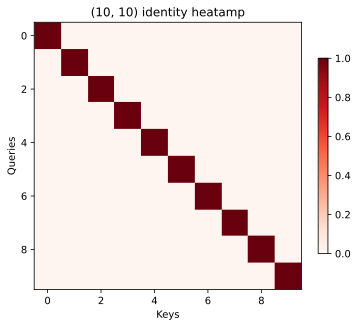

In [111]:
# test 
attention_weights = torch.eye(10).reshape((1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel="Keys", ylabel="Queries", titles=["(10, 10) identity heatamp"], figsize=(6, 6))

#### Generate simple noisy dataset

Here I generate a non-linear dataset with noise. <br>
$$y_{i} = 2sin(x_{i}) + x_i^{0.8} + \epsilon$$

number of training samples: 50, number of test samples: 50


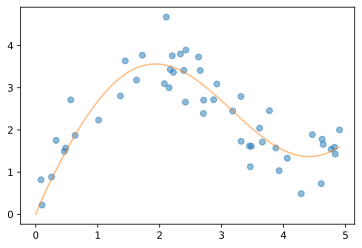

In [112]:
n_train = 50  # number of training data 
x_train, index_original = torch.sort(torch.rand(n_train) * 5) # x_training after sorted -- increasing order 

def f(x):
	return 2 * torch.sin(x) + x**0.8

y_train = f(x_train) + torch.normal(0.0, 0.5, (n_train, )) # mean, std, shape
x_test = torch.arange(0, 5, 0.1)
y_test = f(x_test)

n_test = len(x_test)
print("number of training samples: {}, number of test samples: {}".format(n_train, n_test))

# plot the train and test
d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)
d2l.plt.plot(x_test, y_test, alpha=0.5)
d2l.plt.show()

#### Average pooling

$$f(x) = \frac{1}{n} \sum^n_{i=1} y_i$$

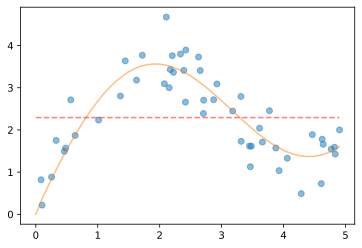

In [113]:
y_pred = torch.repeat_interleave(y_train.mean(), n_test) # input tensor, repeats

d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)
d2l.plt.plot(x_test, y_test, alpha=0.5)
d2l.plt.plot(x_test, y_pred, '--', color = "red", alpha=0.5)
d2l.plt.show()

#### Non-parametric attention pooling (Nadaraya-Watson kernel regression)

Kernel regression proposed by Nadaraya and Watson: <br>

$$f(x) = \sum^{n}_{i=1} \frac{K(x-x_i)}{\sum^{n}_{j=1} K(x-x_j)}$$

Generalizad form of attention pooling: <br>

$$f(x) = \sum^{n}_{i=1} \alpha (x, x_i)y_i$$

For any query, its attention weights over all the key-value pairs are a valid probability distribution: they are non-negative and sum up to one.

Here, I provide a simple example of how a Gaussian kernel applied to generalized form of attention pooling:

$$ K(u) = \frac{1}{\sqrt{2 \pi}} exp(-\frac{u^2}{2})$$

$$ f(x) = \sum^{n}_{i=1} \alpha (x, x_i) y_i = \sum^{n}_{i=1} \frac{exp(-\frac{1}{2} (x-x_i)^2)}{\sum^{n}_{j=1} exp (-\frac{1}{2} (x-x_j)^2)} y_i = \sum^n_{i=1} softmax(-\frac{1}{2} (x-x_i)^2) y_i$$

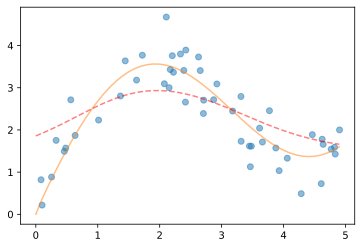

In [114]:
# prediction using Nadaraya-Watson kernel regression 

# shape of X_repeat: (n_test, n_train)
# each row contains the same testing inputs (same queries)
X_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))

# x_train contain the keys
# shape of attention_weights: (n_test, n_train)
# each row contain attention weights to be assigned among the values given each query
attention_weights = nn.functional.softmax(-(X_repeat-x_train)**2 / 2, dim=1)

# each element of y_pred is weighted average of values where weights are attention weights
y_pred = torch.matmul(attention_weights, y_train)

d2l.plt.plot(x_train, y_train, 'o', alpha=0.5)
d2l.plt.plot(x_test, y_test, alpha=0.5)
d2l.plt.plot(x_test, y_pred, '--', color = "red", alpha=0.5)
d2l.plt.show()

In [115]:
attention_weights.unsqueeze(0).shape

torch.Size([1, 50, 50])

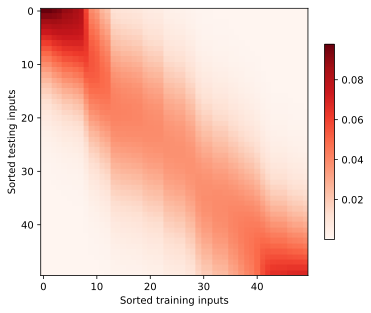

In [116]:
# heatmap of Gaussian kernel regression
# unsqueeze(0) add an additional dimension at position 0

d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0), xlabel="Sorted training inputs", ylabel = "Sorted testing inputs", figsize=(6, 6))

In [117]:
#